# NeuralForceField with AuTopology priors

#### Here we show how to run NeuralForceField with classical fixed priors, and also learnable classical priors based on AuTopology.

We start off with imports:

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader


from nff.data import Dataset, split_train_validation_test
from nff.nn.modules import GraphDis
import pickle
from nff.data.loader import collate_dicts


from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
import json
import pdb
import copy


The dataset we use below was generated in `data/create_dataset_from_file` in the usual way, but with the additional call to the command `generate_topologies()`.

In [2]:
dataset = Dataset.from_file("data/autopology_demonstration.pth.tar")

For reasons that will become clear below, we'll also add some other props to our dataset. These props will be used when we train the AuTopology contribution to the gradient below in Section II.

In [3]:
dataset.props["auto_energy_0_grad"] = dataset.props["energy_0_grad"]
dataset.props["auto_energy_1_grad"] = dataset.props["energy_1_grad"]

Clean out any old work and split the data into testing and training:

In [4]:
DEVICE = 0
OUTDIR = './sandbox'
BATCH_SIZE = 25

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)


train, val, test = split_train_validation_test(dataset, val_size=0.1, test_size=0.1)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

Create the model by setting the SchNet readout dictionary, and some other parameters related to the model. Note that if `trainable_prior` is True then the constants in the classical priors are functions of the atomic environment and can be learned. Otherwise they are set to a reasonable default value and not learned.

In [5]:
n_atom_basis = 256

readoutdict = {
                    "energy_0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}],
                    "energy_1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}]
                }


params = {
    'n_atom_basis': n_atom_basis,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 10,
    'cutoff': 5.0,
    'trainable_gauss': True,
    'schnet_readout': readoutdict,    
    "sorted_result_keys": ["energy_0", "energy_1"],
    "grad_keys": ["energy_0_grad", "energy_1_grad"],
    "trainable_prior": True,
    "autopology_Lh": [40, 20],
    "bond_terms": ["morse"],
    "angle_terms": ["harmonic"],
    "dihedral_terms": ["OPLS"],
    "improper_terms": ["harmonic"],
    "pair_terms": ["LJ"],


}

model = get_model(params, model_type="SchNetAuTopology")




We now set the loss coefficients. We can either choose to evaluate the loss based only on how close the prediction is to the actual for `energy_0`, `energy_1`, and their gradients, or also based on how close the autopology results are to the actual answers. We'll look at each example separately, starting with training based only on the overall loss.

## I. Learnable AuTopology parameters, with a loss function for the combined SchNet + AuTopology result only

In [6]:
loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}
loss_fn = loss.build_mse_loss(loss_coef=loss_coef)

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad')
]


train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

# mini_batches is the number of times you update the loss for a given batch before taking a 
# step in the training. Here we have 25 molecules per batch but 2 mini batches, meaning our loss
# is based on data from 2 x 25 = 50 molecules.

T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


Now train the model:

In [7]:
T.train(device=DEVICE, n_epochs=100)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-05 18:40:39 |     1 |     1.000e-04 | 23403.2111 |      11568.9307 |     160.2695 |           32.5913 |     167.9366 |           32.7889 |            6734
2019-11-05 18:40:40 |     2 |     1.000e-04 | 12296.2119 |      10132.5645 |     145.7891 |           33.0382 |     152.5276 |           33.3070 |            6764
2019-11-05 18:40:41 |     3 |     1.000e-04 | 10987.3872 |       6942.3213 |      97.8555 |           33.4108 |      97.0197 |           33.7644 |            6765
2019-11-05 18:40:42 |     4 |     1.000e-04 | 10759.1429 |       5815.1875 |      72.8546 |           33.1489 |      70.6355 |           33.4694 |            6770
2019-11-05 18:40:42 |     5 |     1.000e-04 | 11698.4258 |       5868.9614 |      78.0037 |           33.4008 |      71.5290 |           33.5042 |            6770
2019-11-05 18:40:43 | 

2019-11-05 18:41:26 |    51 |     1.000e-04 |  2389.0214 |       1354.7279 |      33.7638 |           16.7566 |      35.1957 |           17.0847 |            6773
2019-11-05 18:41:27 |    52 |     1.000e-04 |  2136.4239 |       2005.8987 |      57.2600 |           17.5405 |      51.5480 |           17.7664 |            6773
2019-11-05 18:41:28 |    53 |     1.000e-04 |  2388.3200 |       1427.4290 |      39.9336 |           16.5645 |      40.6285 |           16.9117 |            6773
2019-11-05 18:41:29 |    54 |     1.000e-04 |  2095.0225 |       1351.5571 |      36.0042 |           16.5262 |      27.5864 |           16.8619 |            6773
2019-11-05 18:41:30 |    55 |     1.000e-04 |  1982.8553 |       1334.4685 |      33.3200 |           16.4994 |      28.2695 |           16.8326 |            6773
2019-11-05 18:41:31 |    56 |     1.000e-04 |  1951.3915 |       1401.4666 |      36.7140 |           16.5335 |      35.5727 |           16.8469 |            6773
2019-11-05 18:41:32 | 

Now we'll evaluate the results:

In [8]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

We'll want to compare many different targets and results, so we'll define a function `plot_overall` that plots energies and gradients vs. targets, and a function `plot_autopology`, that compares only the AuTopology part of the gradients to the actual gradients.

In [9]:
def make_plot(key_pairs, results, targets, target_dic=None):
    
    all_keys = np.array(key_pairs).reshape(-1)
    units = dict()
    for key in all_keys:
        if "grad" in key:
            units[key] = r'kcal/mol/$\AA$'
        else:
            units[key] = 'kcal/mol'

    if target_dic is None:
        target_dic = {key: key for key in all_keys}

    for i in range(len(key_pairs)):

        fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

        for ax, key in zip(ax_fig, key_pairs[i]):

            pred = (results[key]).reshape(-1).cpu().detach().numpy()
            target_key = target_dic[key]
            targ = (targets[target_key]).reshape(-1).cpu().detach().numpy()

            ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)

            mae = np.mean(abs(pred-targ))
            if "grad" in key:
                these_units = r"kcal/mol/$\AA$"
            else:
                these_units = r"kcal/mol"
            plt.text(0.1, 0.75, "MAE = {} {}".format(str(round(mae, 1)), these_units), transform=ax.transAxes, fontsize=14)

            lim_min = min(np.min(pred), np.min(targ)) * 1.1
            lim_max = max(np.max(pred), np.max(targ)) * 1.1

            ax.set_xlim(lim_min, lim_max)
            ax.set_ylim(lim_min, lim_max)
            ax.set_aspect('equal')

            ax.plot((lim_min, lim_max),
                    (lim_min, lim_max),
                    color='#000000',
                    zorder=-1,
                    linewidth=0.5)

            ax.set_title(key.upper(), fontsize=14)
            ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
            ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)


def plot_overall(results, targets):
    key_pairs = [["energy_0", "energy_0_grad"], ["energy_1", "energy_1_grad"]]
    make_plot(key_pairs, results, targets)

def plot_autopology(results, targets):
    key_pairs = [["auto_energy_0_grad", "auto_energy_1_grad"]]
    target_dic = {"auto_energy_0_grad": "energy_0_grad", "auto_energy_1_grad": "energy_1_grad"}
    make_plot(key_pairs, results, targets, target_dic)

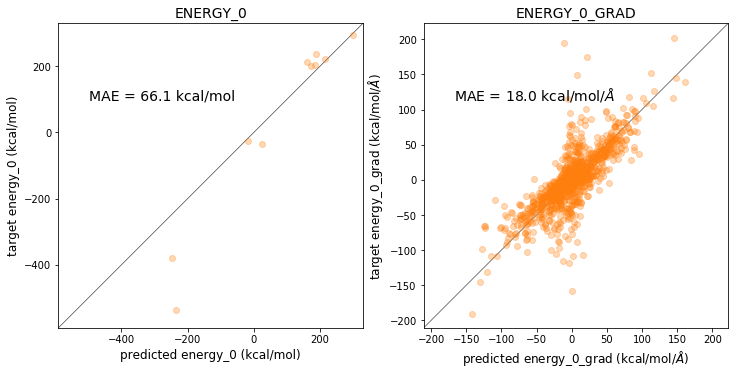

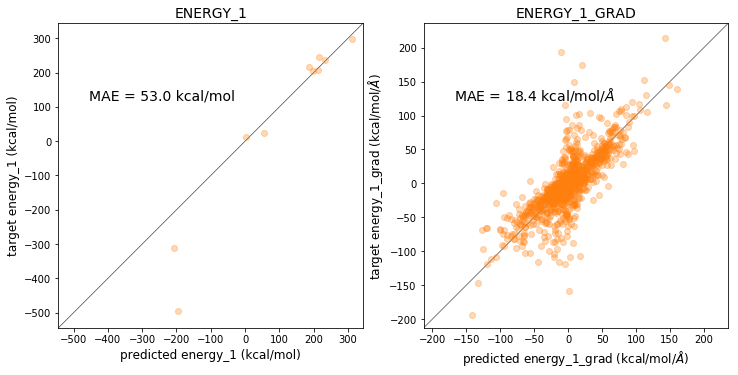

In [10]:
plot_overall(results, targets)

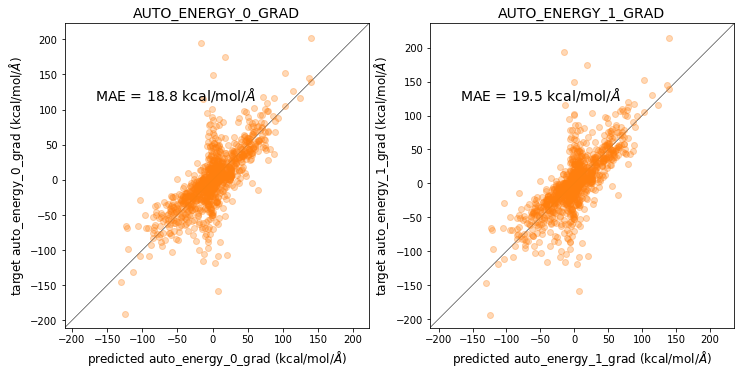

In [11]:
plot_autopology(results, targets)

We can see that the AuTopology terms are doing most of the work here. The difference in gradient error between the AuTopology contribution and the full AuTopology + SchNet result is pretty small. This is interesting, considering that we penalized only errors in the full AuTopology + SchNet result, and not in the AuTopology result alone.

## II. Learnable AuTopology parameters, with a loss function for the combined SchNet + AuTopology result *and* for the AuTopology part of the result

In [12]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)



In [13]:
new_model = get_model(params, model_type="SchNetAuTopology")
new_loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0,
            'auto_energy_0_grad': 10.0, 'auto_energy_1_grad': 10.0}

new_loss_fn = loss.build_mse_loss(loss_coef=new_loss_coef)
trainable_params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad')
]


train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

new_T = Trainer(
        model_path=OUTDIR,
        model=new_model,
        loss_fn=new_loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )

In [14]:
new_T.train(device=DEVICE, n_epochs=100)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-05 18:42:14 |     1 |     1.000e-04 | 79730.0938 |      56577.1328 |      96.0443 |           36.6112 |      81.0510 |           37.0079 |            6774
2019-11-05 18:42:15 |     2 |     1.000e-04 | 62323.3445 |      48279.5273 |     120.7886 |           33.0192 |     107.8749 |           33.4435 |            6801
2019-11-05 18:42:16 |     3 |     1.000e-04 | 53874.3186 |      45779.0938 |     127.8990 |           31.9069 |     113.5186 |           32.3174 |            6801
2019-11-05 18:42:17 |     4 |     1.000e-04 | 51302.1736 |      42400.6562 |     118.8741 |           30.9717 |     101.7932 |           31.3435 |            6801
2019-11-05 18:42:18 |     5 |     1.000e-04 | 48795.0764 |      38214.8281 |      99.9810 |           29.5853 |      79.9241 |           30.0170 |            6801
2019-11-05 18:42:19 | 

2019-11-05 18:43:05 |    51 |     1.000e-04 | 10014.1782 |       7339.8989 |      57.8201 |           11.7705 |      47.6797 |           12.1049 |            6801
2019-11-05 18:43:06 |    52 |     1.000e-04 |  9927.1034 |       7291.3955 |      52.5507 |           12.1041 |      44.7885 |           12.2943 |            6801
2019-11-05 18:43:07 |    53 |     1.000e-04 |  9833.5302 |       7157.5098 |      50.6085 |           11.8657 |      43.2395 |           12.0310 |            6801
2019-11-05 18:43:08 |    54 |     1.000e-04 |  9622.8728 |       7118.7612 |      54.9423 |           11.7136 |      45.6390 |           12.0110 |            6801
2019-11-05 18:43:09 |    55 |     1.000e-04 |  9542.7175 |       7043.1748 |      51.3099 |           11.7868 |      44.0142 |           12.0440 |            6801
2019-11-05 18:43:10 |    56 |     1.000e-04 |  9407.0142 |       7048.0518 |      52.1950 |           11.7460 |      44.0221 |           11.9830 |            6801
2019-11-05 18:43:11 | 

In [15]:
new_results, new_targets, new_val_loss = evaluate(new_model, test_loader, new_loss_fn, device=DEVICE)

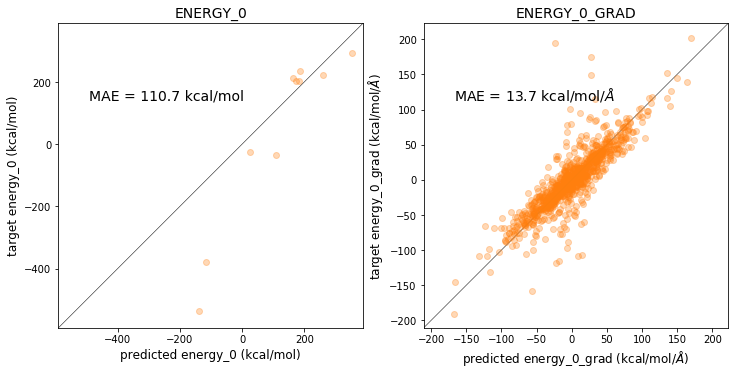

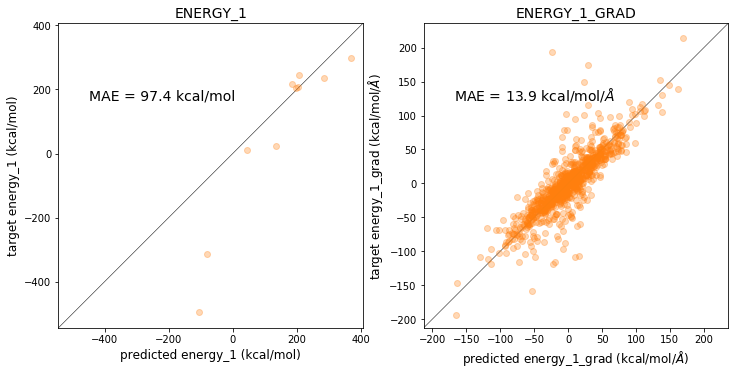

In [16]:
plot_overall(new_results, new_targets)

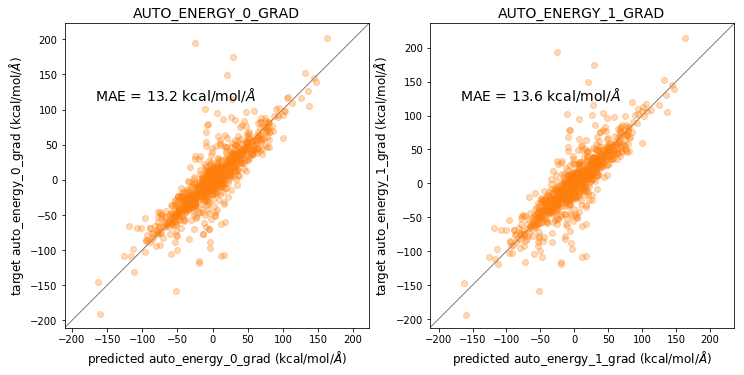

In [17]:
plot_autopology(new_results, new_targets)

These results are interesting! The agreement between both the AuTopology gradients and the full gradients with the actual gradients is much better than before. They're also better than the overall gradients of the last example. Indeed, I have found that for much larger datasets, the forces with SchNet + AuTopology are learned far more quickly than the forces with just SchNet.

However, the energies are worse than before. Maybe AuTopology energies add an energy offset in the wrong direction that SchNet has to work against.

## III. Non-learnable AuTopology parameters

Lastly we set the AuTopology parameters to fixed, non-learnable parameters:

In [18]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)



final_params = copy.copy(params)
final_params.update({"trainable_prior": False})

final_model = get_model(final_params, model_type="SchNetAuTopology")
final_loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}

final_loss_fn = loss.build_mse_loss(loss_coef=final_loss_coef)
trainable_params = filter(lambda p: p.requires_grad, final_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad')
]


train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

final_T = Trainer(
        model_path=OUTDIR,
        model=final_model,
        loss_fn=final_loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )



In [19]:
final_T.train(device=DEVICE, n_epochs=100)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-05 18:43:57 |     1 |     1.000e-04 | 12850.2383 |      10906.3887 |     162.8403 |           33.0388 |     148.9494 |           33.2773 |            6801
2019-11-05 18:43:58 |     2 |     1.000e-04 | 11943.6437 |       8992.5332 |     140.5901 |           33.0765 |     122.8981 |           33.3468 |            6801
2019-11-05 18:43:58 |     3 |     1.000e-04 | 11461.3899 |       7301.7710 |     115.3341 |           33.1445 |      99.9822 |           33.4099 |            6801
2019-11-05 18:43:59 |     4 |     1.000e-04 | 11602.3752 |       6398.1152 |      94.5379 |           33.2021 |      86.7446 |           33.4117 |            6801
2019-11-05 18:44:00 |     5 |     1.000e-04 | 11991.0763 |       6180.2246 |      87.1045 |           33.2016 |      85.0152 |           33.3405 |            6801
2019-11-05 18:44:00 | 

2019-11-05 18:44:33 |    51 |     1.000e-04 |  3211.6359 |       2430.8235 |      51.8459 |           20.2735 |      48.8062 |           20.7007 |            6801
2019-11-05 18:44:34 |    52 |     1.000e-04 |  3120.2160 |       2479.9763 |      55.6600 |           20.0847 |      49.2319 |           20.4020 |            6801
2019-11-05 18:44:35 |    53 |     1.000e-04 |  3059.4559 |       2235.2600 |      50.3013 |           19.8327 |      46.1199 |           20.1609 |            6801
2019-11-05 18:44:35 |    54 |     1.000e-04 |  2964.7244 |       2328.7319 |      54.9948 |           19.5868 |      49.6517 |           19.8152 |            6801
2019-11-05 18:44:36 |    55 |     1.000e-04 |  2958.6027 |       2068.5593 |      48.1899 |           19.3967 |      44.4813 |           19.6034 |            6801
2019-11-05 18:44:37 |    56 |     1.000e-04 |  2880.1517 |       2204.1289 |      54.0262 |           19.2375 |      47.8300 |           19.2884 |            6801
2019-11-05 18:44:38 | 

In [20]:
final_results, final_targets, final_val_loss = evaluate(final_model, test_loader, final_loss_fn, device=DEVICE)

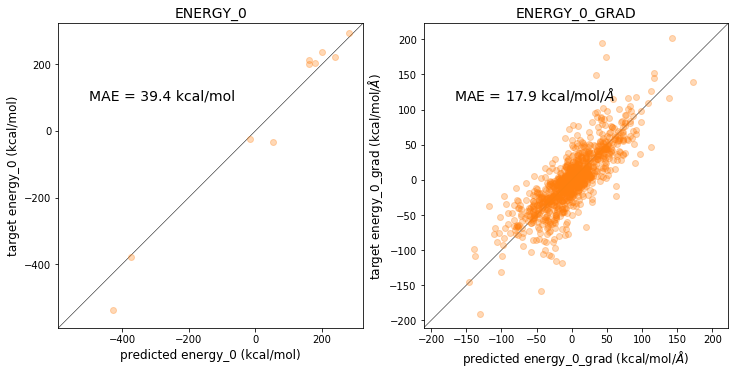

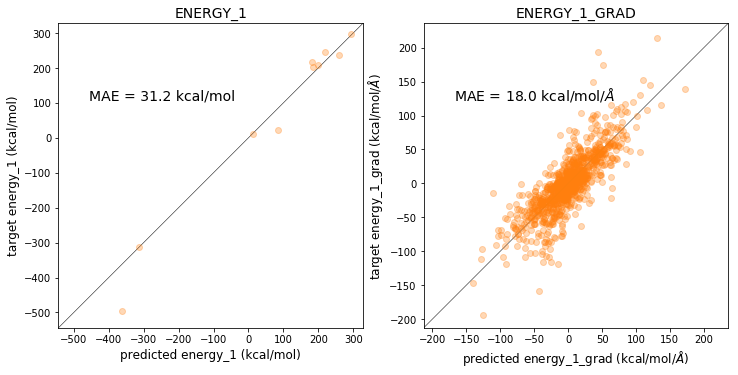

In [21]:
plot_overall(final_results, final_targets)

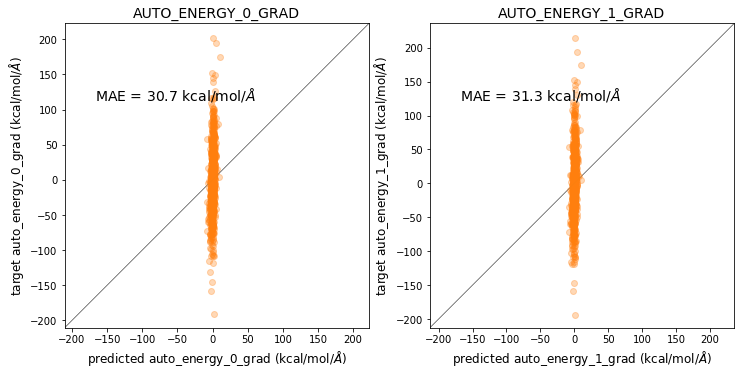

In [22]:
plot_autopology(final_results, final_targets)

When the AuTopology parameters aren't learnable, there is no correlation between the autopology part of the gradients and the overall gradients, as expected. If we don't treat them as trainable then they're just there to make sure our molecules don't explode during MD simulations.

The forces are of comparable accuracy here to in the first case and not as good as the second case. The energies are actually better than in the other two cases!
